### Ecole des Mines de Paris
### Problemes Inverses - S1923

### Binome: Felipe MORET et Giovani MERLIN

# Projet nº5 - Tomographie à rayons parallèles



<blockquote>
<p> Ce projet consiste à étudier le problème de découvrir la forme d’un objet en utilisant tomographie à rayons parallèles. On fait cette technique  en émettant des rayons électromagnétiques parallèlement à une coupe transversale de l'objet et ensuite en mesurant l'intensité de ces rayons quand ils sortent de l’autre côté du objet.</p>

<p> Selon la <b>Figure 1</b> ci-dessous, on peut calculer l'intensité des rayons en utilisant une fonction $f(x,y)$, sur chaque point $(x,y)$ de l'espace. Pour avoir plus précision, nous répétons le processus de mesure pour différents angles $\theta$, en analysant toutes les perspectives possibles.



</blockquote>


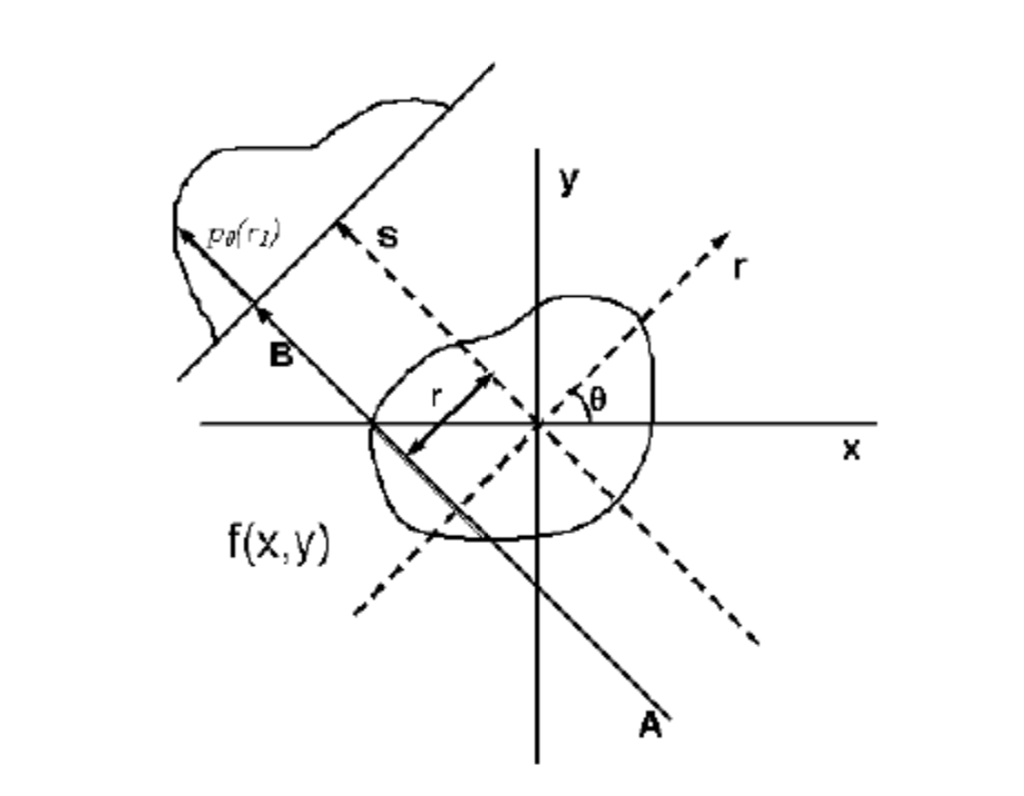

In [0]:
from IPython.display import Image
Image(filename="/figure1.png", width = 400, height = 400)

<blockquote>

Le modèle est donné par : <br>
$$ b = ln(\frac{I}{I_0}) = -\int_{\gamma} \mu(x,y)dl.$$ 

&nbsp;&nbsp;&nbsp;&nbsp; Ici, $I$ est l'intensité mesurée du rayon, $I_{0}$ est son intensité initiale, et le modède ci-dessus nous dit que une relation logarithmique peut être calculée en utilisant une intégrale de chemin sur le rayon emisé $\gamma$ d'une certaine fonction $f(x,y)
$. Notre but ici est de résoudre le problème inverse: en sachant quelques mésures de $b$, on veut retrouver la fonction $f$.

&nbsp;&nbsp;&nbsp;&nbsp; On a besoin maintenant de choisir une manière de discrétiser l'espace d'observation: la méthode la plus intuitive consiste à considérer que l'espace est divisé en $N^{2}$ cellules carées. La figure ci-dessous illustre cette idée: 
</blockquote>



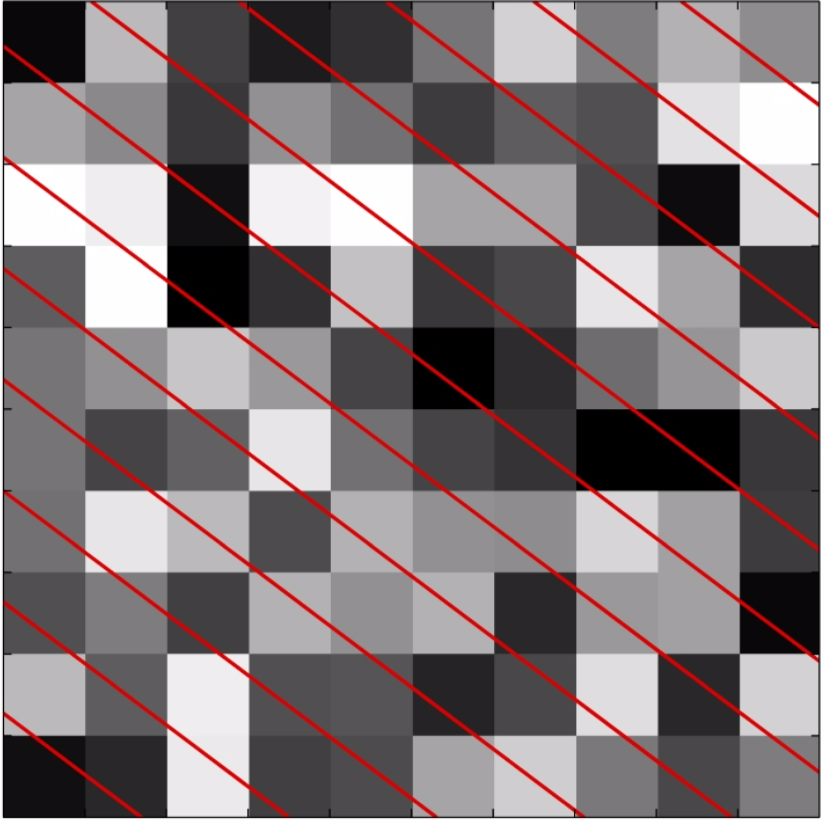

In [0]:
from IPython.display import Image
Image(filename="/figure2.png", width = 400, height = 400)

<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; Après que l'on a décidé comment discrétiser l'espace, on doit vraiment choisir comment faire les mesures: on choisi une quantité finie $N_{\theta}$ de valeurs pour l'angle de balayge $\theta$ et pour chaque angle $\theta$ on fait les mésures pour $p$ rayons émis.

&nbsp;&nbsp;&nbsp;&nbsp; Alors, l'équation du modèle devient maintenant:

$$
b= Af,
$$

où $b \in \mathbb{R}^{p\times N_{\theta}}$ est la matrice de données, $A$ est la matrice de discrétisation de l'intégrale presente dans le modèle orginal et $f \in \mathbb{R}^{N\times N}$ est la matrice inconnue qui donne le comportement de la fonction objective. 



</blockquote>

In [0]:
import numpy as np
from numpy import matlib as mb
import math

def makephantom(N,example):

 #MAKEPHANTOM creates the modified Shepp-Logan phantom
 #   X = myphantom(N)
 # 
 # This function create the modifed Shepp-Logan phantom with the
 # discretization N x N, and returns it as a vector.
 #
 # Input:
 #   N    Scalar denoting the nubmer of discretization intervals in each
 #        dimesion, such that the phantom head consists of N^2 cells.
 # 
 # Output:
 #   X    The ellipse phantom  reshaped as a vector

 #         A    a     b    x0    y0    phi
 #        ---------------------------------


    if(example == 1):
        e = np.array([  1  , .29 , .52  ,  0   ,  0   ,  0   ])
    if(example == 2):
        e = np.array([  1  , .52  , .29  ,  0  ,   0  ,   0   ])
    if(example == 3):
        e = np.array([  1  , .52  , .29  ,  0   ,  0   ,  45  ])
    

    xn = np.linspace(-1,1,N)
    Xn = mb.repmat(xn,N,1);
    Yn = np.rot90(Xn);
    X = np.zeros(N*N);

    # For each ellipse to be added     
    # for i in range(e.shape[0]):
    for i in range(1):
        a2 = e[1]**2
        b2 = e[2]**2
        x0 = e[3]
        y0 = e[4]
        phi = e[5]*math.pi/180
        A = e[0]

        x = Xn-x0;
        y = Yn-y0;
        
        v = ( ((x*math.cos(phi) + y*math.sin(phi))**2)/a2 + 
            ((y*math.cos(phi) - x*math.sin(phi)))**2/b2 )
        
        
        
    # Add the amplitude of the ellipse
        v = np.ravel(v.T)
        index = np.argwhere( v<= 1)
        X[index] = X[index] + A


# Return as vector and ensure nonnegative elements.
    X = np.ravel(X)
    X[X<0] = 0
    X = np.array(X)
    return X



In [0]:
import numpy as np
from scipy.sparse import lil_matrix
import math as math

####  MY FORMAT VARIABLE
myfloat = np.float32

####  MY CONSTANTS
eps = 1e-10
infp = 1e20
infn = -infp    

def paralleltomo(N,theta = np.arange(0,179), p=0 ,d = 0 ,isDisp = 0):
  

 #PARALLELTOMO Creates a 2D tomography test problem using parallel beams
 #
 #   [A theta p d] = paralleltomo(N)
 #   [A theta p d] = paralleltomo(N,theta)
 #   [A theta p d] = paralleltomo(N,theta,p)
 #   [A theta p d] = paralleltomo(N,theta,p,d)
 #   [A theta p d] = paralleltomo(N,theta,p,d,isDisp)
 #
 # This function creates a 2D tomography test problem with an N-times-N
 # domain, using p parallel rays for each angle in the vector theta.
 #
 # Input: 
 #   N           Scalar denoting the number of discretization intervals in 
 #               each dimesion, such that the domain consists of N^2 cells.
 #   theta       Vector containing the angles in degrees. Default: theta = 
 #               0:1:179.
 #   p           Number of parallel rays for each angle. Default: p =
 #               round(sqrt(2)*N).
 #   d           Scalar denoting the distance from the first ray to the last.
 #               Default: d = sqrt(2)*N.
 #   isDisp      If isDisp is non-zero it specifies the time in seconds 
 #               to pause in the display of the rays. If zero (the default), 
 #               no display is shown.
 #
 # Output:
 #   A           Coefficient matrix with N^2 columns and nA*p rows, 
 #               where nA is the number of angles, i.e., length(theta).
 #   theta       Vector containing the used angles in degrees.
 #   p           The number of used rays for each angle.
 #   d           The distance between the first and the last ray.
 # 
 # See also: fanbeamtomo, seismictomo.

 # Jakob Heide Jï¿½rgensen, Maria Saxild-Hansen and Per Christian Hansen,
 # June 21, 2011, DTU Informatics.

 # Reference: A. C. Kak and M. Slaney, Principles of Computerized 
 # Tomographic Imaging, SIAM, Philadelphia, 2001.

 # Default illustration:

  if not p:
    p = round(math.sqrt(2)*N)
  if not d:
    d = math.sqrt(2)*N

  # Define the number of angles.
  M = len(theta) # nA = M
  theta = theta * np.pi / 180.0

  # The starting values both the x and the y coordinates. 
  x0 = np.linspace(-d/2,d/2,p)

  y0 = np.zeros(p, dtype = myfloat)

  # The intersection lines.
  x = np.arange(-N/2,N/2+1)
  y = x.copy()
  rows = M*p
  cols = N**2
  A = lil_matrix( (rows,cols) , dtype = myfloat)

  ##  Initialize vectors that will be used inside the main loop
  x0theta = x0.copy(); y0theta = y0.copy()
  tx = x.copy(); ty = x.copy(); xy = x.copy(); yx = x.copy()
  t = np.zeros( 2 * len( x ) , dtype=myfloat )


  # Loop over the chosen angles.
  for i in range(M):
      
      # All the starting points for the current angle.
      ##  Get all the starting points for the current angle
      s = np.sin( theta[i] )
      c = np.cos( theta[i] )
      x0theta[:] = c * x0 - s * y0
      y0theta[:] = s * x0 + c * y0

      # Loop over the rays.
      for j in range (p):

            ##  Use the parametrisation of line to get the y-coord.
            ##  of intersections with x = k, i.e. x constant
            if np.abs( s ) > eps: # empeche division par zero.
                tx[:] =  - ( x - x0theta[j] ) / s
            else:
                tx[ (-( x - x0theta[j]) >= 0 ) ] = infp
                tx[ (-( x - x0theta[j] ) < 0 ) ] = infn
            yx[:] = c * tx + y0theta[j] 
                


            ##  Use the parametrisation of line to get the x-coord.
            ##  of intersections with y = k, i.e. y constant
            if np.abs( c ) > eps:             
                ty[:] = ( y - y0theta[j] ) / c
            else:
                ty[ ( ( y - y0theta[j] ) >= 0 ) ] = infp
                ty[ ( ( y - y0theta[j] ) < 0 ) ] = infn    
            xy[:] =  -s * ty + x0theta[j]    

          
          # Collect the intersection times and coordinates. 
            t[:] = np.concatenate( ( tx , ty ) , axis=0 )
            xxy = np.concatenate( ( x , xy ) , axis=0 )
            yxy = np.concatenate( ( yx , y ) , axis=0 )

          
            # Sort the coordinates according to intersection time.
            I = np.argsort(t) #index that sort t
            t[:] = t[I] #np.sort( t )
            xxy[:] = xxy[I]

            yxy[:] = yxy[I]        
            
            # Skip the points outside the box.
            # & elementwise ('and' is ambigous)
            I = np.argwhere( ~(( xxy >= -N/2 ) & ( xxy <= N/2 ) &
             ( yxy >= -N/2 ) & ( yxy <= N/2 )) )
            #Argwhere return the elements by [line,column] that are bigger than 1          

            
            xxy = np.delete( xxy , I )
            yxy = np.delete( yxy , I )
            
            # Skip double points.
            I = np.argwhere( ( np.abs( xxy[1:] - xxy[:-1] ) < eps ) & \
                             ( np.abs( yxy[1:] - yxy[:-1] ) < eps ) )
            if len( I ) != 0:
                xxy = np.delete( xxy , I )
                yxy = np.delete( yxy , I )

            # Calculate the length within cell and determines the number of
            # cells which is hit.
            # Do the diff ( after - before)
            d = np.sqrt( ( xxy[1:] - xxy[:-1] )**2 + ( yxy[1:] - yxy[:-1] )**2 )
            numvals = len( d )
            
            # Store the values inside the box.
            if numvals > 0:
                
                # If the ray is on the boundary of the box in the top or to the
                # right the ray does not by definition lie with in a valid cell.
                cond1 = ( s == 0.0 ) and ( np.abs( x0theta[j] - N/2 ) < eps )
                cond2 = ( c == 0.0 ) and ( np.abs( y0theta[j] - N/2 ) < eps )
                if( not (cond1 or cond2) ):
                    
                    # Calculates the midpoints of the line within the cells.
                    xm = 0.5 * ( xxy[:-1] + xxy[1:] )  + N/2

                    ym = 0.5 * ( yxy[:-1] + yxy[1:] )  + N/2

                    # Translate the midpoint coordinates to index.
                    cols = np.floor( xm ) * N + ( N - 1 - np.floor( ym ) )
                    cols = cols.astype( int )
                    cols = cols.reshape(-1)

                    row = i * p + j
                    A[row,cols] = d



  # Create sparse matrix A from the stored values.
  A = np.array(A.todense())
  return A, theta, p


In [0]:
N = 40
sigma = 1e-1
theta = np.arange(0,359,20)
f = makephantom(N,3)

A ,_ ,p = paralleltomo(N,theta)
b = np.matmul(A,f)
print("f dim :",f.shape)
print("A dim :",A.shape)
print("b dim :", b.shape)
print("p :",p)
bMesure = np.array(b + sigma*np.random.randn(b.shape[0]))
fReconst = np.linalg.lstsq(A,bMesure) #Least Squares method
fReconst = np.array(fReconst[0])


f dim : (1600,)
A dim : (1026, 1600)
b dim : (1026,)
p : 57


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; On a commencé l'étude du problème de tomographie en établissant une discrétisation du milieu avec <b><font color="red">$N=40$</font></b>, c'est-à-dire, on a discrétisé le milieu en <b>$40^{2}$</b> cellules. A partir de cette discrétisation, on a généré la matrice $f$ en utilisant la fonction <b><i>makephantom</i></b>: cette fonction a le but de créer exemples de corps differents pour l'analyse. La première figure ci-dessous montre l'objet généré.

&nbsp;&nbsp;&nbsp;&nbsp; Ensuite, la fonction <b><i>paralleltomo</i></b> prend la valeur $N$ et le vecteur de valeurs de $\theta$, que l'on a choisi comme $\theta_{k} = 20k, k \in \{0,1,...,17\}$, et à la fin, la fonction renvoie le nombre de rayons $p$ pour lesquels nous effectuerons les mesures pour chaque angle $\theta_{k}$. L'étape suivante consiste à créer la matrice $b$ en faisant $b = Af$.


&nbsp;&nbsp;&nbsp;&nbsp; La deuxième figure ci-dessous montre les valeurs de la matrice $b$. Il est important de souligner que pour générer la matrice $b$ plus réellement, nous ajoutons un bruit aléatoire à cette matrice à la fin du produit qui l'a définie, en utilisant la fonction <b><i>sigma</i></b>. 



</blockquote>

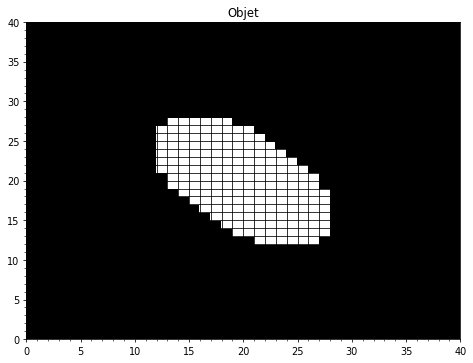

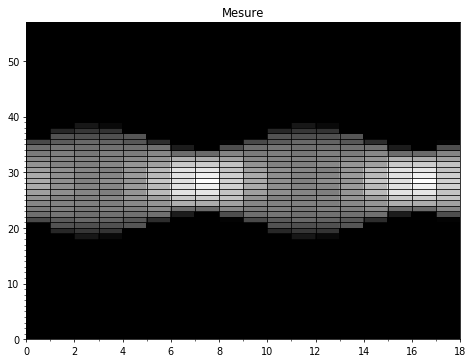

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(8, 6),dpi=70 )
ax = fig.gca()
ax.set_title('Objet')

ax.set_xticks(range(N), minor=True)
ax.set_yticks(range(N), minor=True)
ax.pcolor(np.reshape(f,(N,N)).T, cmap = 'gray')
ax.grid(True, which = 'both', color = 'k')



fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Mesure')
ax.set_xticks(range(N), minor=True)
ax.set_yticks(range(N), minor=True)
ax.pcolor(np.reshape(b,(theta.shape[0],p)).T, cmap = 'gray')
ax.grid(True, which = 'both', color = 'k')




<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; Finalement, en ayant la matrice $b$, on peut retouver la matrice $f$ en utilisant la méthode de <b> moindres carrés </b>. L'implémentation de cette méthode est déjà disponible en <b><i> Python </i></b> et alors, on a mis en oeuvre une fonction <b><i> fReconst</b></i> en faisant:

<center>
<b><i><font color="red">  fReconst = np.linalg.lstsq(A,bMesure)</font> </b></i> 
</center>

&nbsp;&nbsp;&nbsp;&nbsp; Sur la dernière figure ci-dessous, on observe le resultat de la reconstruction. On peut voir qu'il y a une grande différence entre le corps original et le corps reconstruit. Cette différence est due au bruit aléatoire que l'on a introduit. Pour améliorer la reconstruction, on va utiliser une technique de régularisation qui s'appelle <b> Méthode de Tikhonov </b>. 




</blockquote>

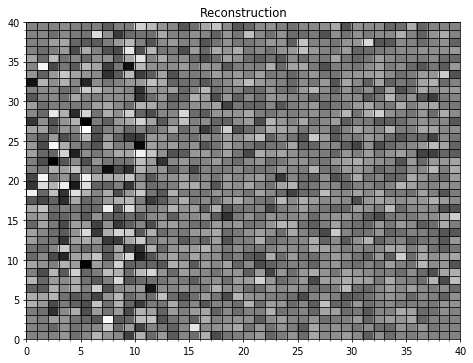

In [0]:
fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Reconstruction')
ax.set_xticks(range(N), minor=True)
ax.set_yticks(range(N), minor=True)
ax.pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
ax.grid(True, which = 'both', color = 'k')

<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; <b> La méthode de régularisation de Tikhonov </b> consiste à résoudre le problème de moindres carrés avec <b> <font color="red">  un terme supplémentaire </font></b> donné par $\epsilon ||f||^{2}$:

$$
min_{f} || Af - b||^{2} + \epsilon ||f||^{2}. 
$$

&nbsp;&nbsp;&nbsp;&nbsp; Notre but maintenant est de choisir un bon paramètre $\epsilon$. Bien sûr, quand $\epsilon$ est proche de zéro, notre solution sera proche d'une solution classique donné pour la méthode de moindres carrés.

&nbsp;&nbsp;&nbsp;&nbsp; Sur la première image ci-dessous, on montre l'image qui a été reconstruit en utilisant différentes valeurs de $\epsilon$. On peut percevoir que si $\epsilon$ est très petit, comme $\epsilon < 10^{-1.5}$, on va obtenir une reconstrution de basse qualité, très proche de la solution pour moindres carrés. Par contre, quand on commence à augmenter la valeur de $\epsilon$, la qualité de la reconstrution commence à s'améliorer jusqu'à ce que $\epsilon <10$


&nbsp;&nbsp;&nbsp;&nbsp; Pour mésurer la qualité de la reconstrution, on utilise la norme de la différence entre les valeurs obtenues $fReconst$ <b> (en utilisant la Méthode de Tikhonov)</b> et les valeurs réelles , c'est-à-dire, <b> $|b_{Mesure} - b_{Reconst}|$</b>. On peut voir que la valeur minimale de la <b> norme de la différence </b> a été obtenue pour les valeurs de $\epsilon$ entre $10^{-1.5}$ et $10^{0.5}$.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


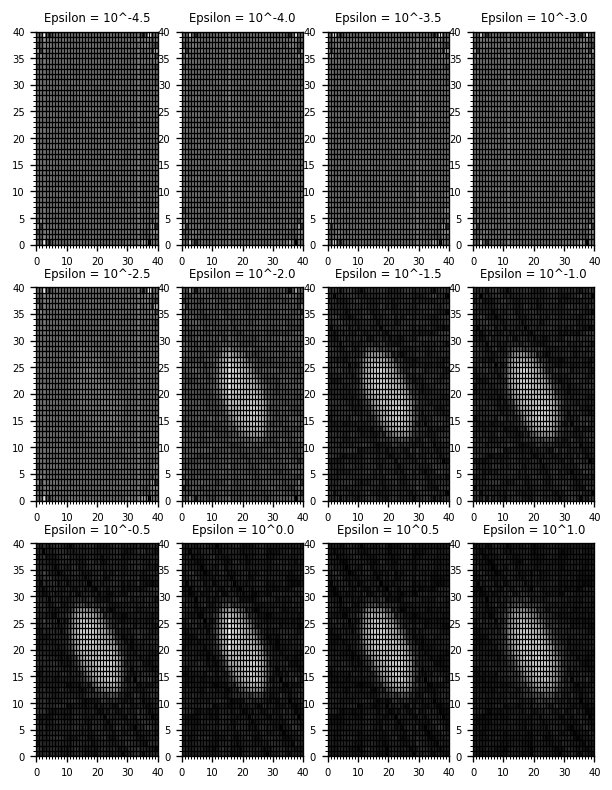

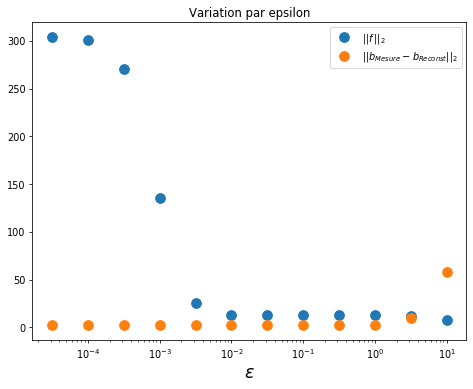

In [0]:
# Régularisation par Tikhonov

epsilon = 10**-4.5
nEps = 12
m = math.floor(math.sqrt(nEps))
n = math.ceil(nEps/m)

b_ = np.concatenate( (bMesure, np.zeros(N**2) ) ,axis=0)

vecEps = np.zeros(nEps)
modf = np.zeros(nEps)
errB = np.zeros(nEps)

fig, ax = plt.subplots(m,n, figsize= (6,8), dpi = 120 )
ax = ax.flatten()

for i in range(nEps):
    A_ = np.concatenate( (A, epsilon*np.eye(N**2) ),axis = 0)
    #b_ = np.concatenate( (bMesure, epsilon*sigma*np.random.randn(N**2)) ,axis=0)
    fReconst = np.linalg.lstsq(A_,b_) 
    fReconst = np.array(fReconst[0])
    bReconst = np.matmul(A,fReconst)
    
    vecEps[i] = epsilon
    modf[i] = np.linalg.norm(fReconst)
    errB[i] = np.linalg.norm(bReconst-bMesure)
    
    ax[i].set_xticks(range(N), minor=True)
    ax[i].set_yticks(range(N), minor=True)
    ax[i].pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
    ax[i].set_title("Epsilon = 10^" + str(round(math.log10(epsilon),3)), fontsize = 7)
    ax[i].tick_params(axis='both', which='both', labelsize=6)
    ax[i].grid(True, which = 'both', color = 'k')
    epsilon = epsilon*math.sqrt(10);


fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Variation par epsilon')
ax.set_xlabel('$\epsilon$', fontsize= 18)
ax.semilogx(vecEps,modf,'.',vecEps,errB,'.', MarkerSize = 20)
ax.legend(['$||f\,||_2$','$||b_{Mesure} - b_{Reconst}||_2$'])

Pour plus de précision on examine la curve L, obtenue par le plot de $||b_{Mesure} - b_{Reconst}||_2$ par $||f\,||_2$, on peux percevoir que le valeur de $\epsilon$ correspondant au coin est entre entre la septième et la huitième valeur de $\epsilon$. Donc, nous choisirons la valeur optimale $\epsilon$ comme le huitième, c'est-à-dire, $\epsilon = 10^{-0.5}$


Eps 7 -1.0 eps 8 -0.5


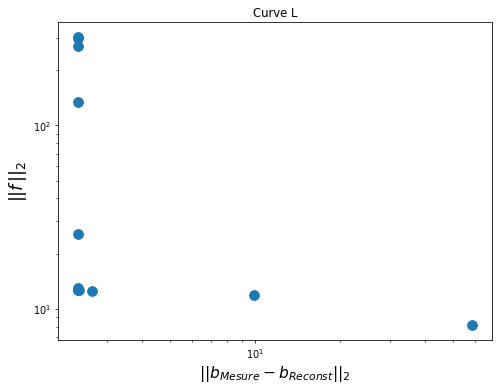

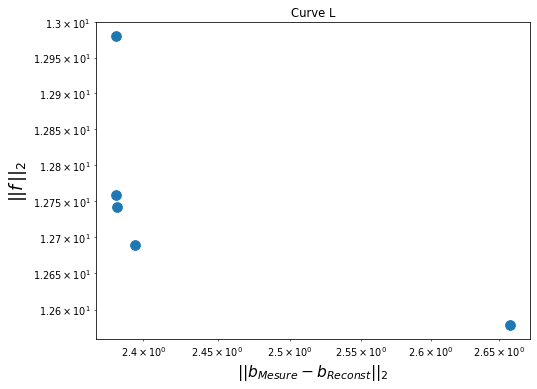

In [0]:
fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Curve L')
ax.set_xlabel('$||b_{Mesure} - b_{Reconst}||_2$', fontsize= 16)
ax.set_ylabel('$||f\,||_2$', fontsize= 18)
ax.loglog(errB,modf,'.', MarkerSize = 20)

fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Curve L')
ax.set_xlabel('$||b_{Mesure} - b_{Reconst}||_2$', fontsize= 16)
ax.set_ylabel('$||f\,||_2$', fontsize= 18)
ax.loglog(errB[5:10],modf[5:10],'.', MarkerSize = 20)
print('Eps 7', str(round(math.log10(vecEps[7]),3)),'eps 8',str(round(math.log10(vecEps[8]),3)) )

<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; Pour faire l'analyse de l'influence du nombre de rayons et de l'angle de coverture, on commence en fixant le même ensemble $\{𝜃_{k} =2 0𝑘,𝑘∈{0,1,...,17}\}$ qui ont déjà défini et on faire varier les valeurs de $p$, c'est-à-dire, le nombre de rayons.

&nbsp;&nbsp;&nbsp;&nbsp; Maintenant, on déjà sait que avec $\epsilon^{*} = 10^{-0.5}$ la régularisation aide à diminuer la mesure d'erreurs <b> $|b_{Mesure} - b_{Reconst}|$</b>. Alors, on va générer des nouvelles matrices $A$ et des nouveaux données $bMesure$ <b>(bien sûr, avec des bruits aléatoires)</b> et après on résodure le problème inverse de calculer $f$ en utilisant la Méthode de Tikhonov avec paramètre $\epsilon^{*}$. 

&nbsp;&nbsp;&nbsp;&nbsp;  <b> <font color="red">Il n'y a pas de doute que pour les nombres de rayons utilisés $p$ plus grands, le résultat $f$ trouvé s'approche plus de la solution réelle</font></b>. Une importante observation est que quand $p$ est grande, $\epsilon$ peut être plus petit.

&nbsp;&nbsp;&nbsp;&nbsp; Pour le cas du l'angle de couverture, on fixe la valeur de $p$ et on faire varier $\theta$ avec differents pas de rotation, plus specifiquement nous testons avec les valeurs $\delta = \{1 °,5 °,10 °,20 °\}$. <b> <font color="red">C'est clair que quand l'angle de couverture est plus petite, la forme retrouvée est plus proche de la forme réelle</font></b>.

&nbsp;&nbsp;&nbsp;&nbsp; La conclusion finale est claire: en augmentant le nombre de rayons et le nombre d'angles d'observation on s'approche plus de la forma du objet:  <b> <font color="red"> avec plus d'informations, on a plus précision</font></b>.

</blockquote>




B (720,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


B (1224,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


B (1800,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


B (2160,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


B (3600,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep us

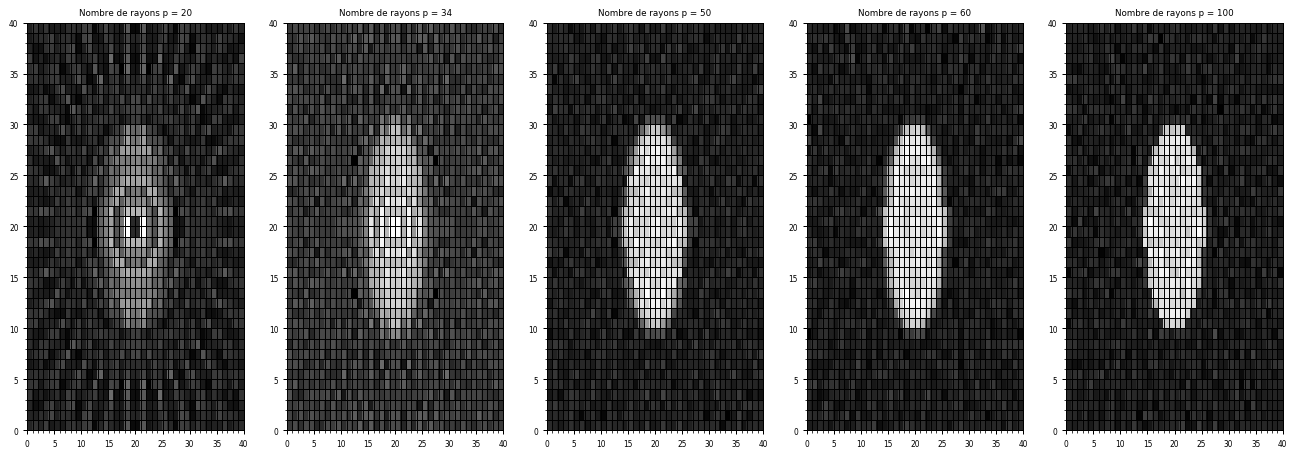

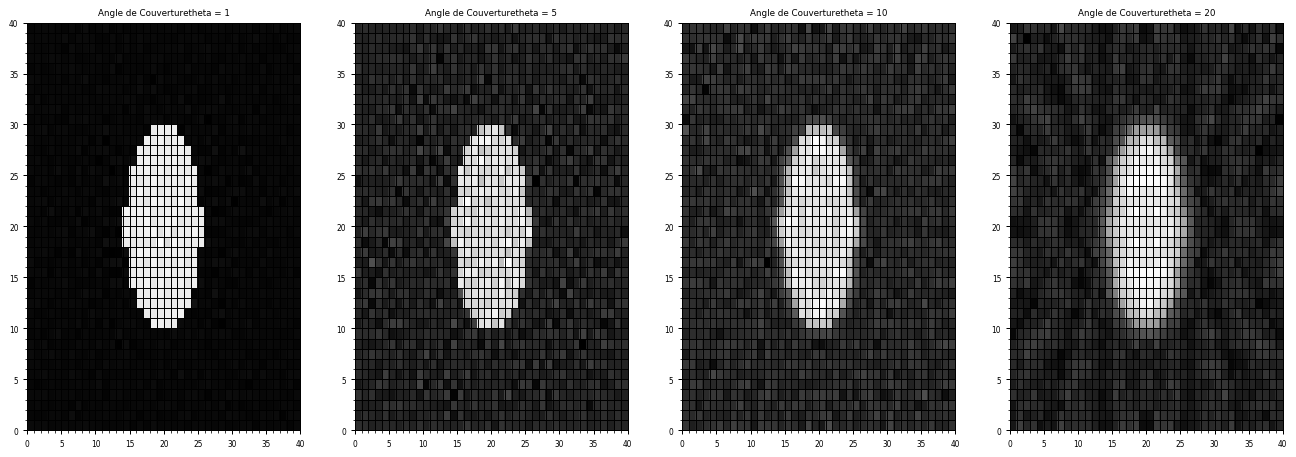

In [0]:
# Étude de l’influence du nombre de rayons, et de l’angle de couverture

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

theta = np.arange(0,359,10)
p = [20, 34, 50 , 60, 100]
sigma = 1e-1
N = 40
f = makephantom(N,1)

fig, ax = plt.subplots(1,len(p), figsize= (18,6), dpi = 90 )
ax = ax.flatten()

for i in range(len(p)):
    A, d ,p[i] = paralleltomo(N,theta,p[i])
    b = np.matmul(A,f)
    bMesure = b + sigma*np.random.randn(b.shape[0])

    print("B", bMesure.shape)
    epsilon = 10**-0.5
    A_ = np.concatenate( (A, epsilon*np.eye(N**2) ),axis = 0)
    b_ = np.concatenate( (bMesure, np.zeros(N**2)) ,axis=0)
    fReconst = np.linalg.lstsq(A_,b_) 
    fReconst = np.array(fReconst[0])

    ax[i].set_xticks(range(N), minor=True)
    ax[i].set_yticks(range(N), minor=True)
    ax[i].pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
    ax[i].set_title("Nombre de rayons " + "p = " + str(p[i]), fontsize = 7)
    ax[i].tick_params(axis='both', which='both', labelsize=6)
    ax[i].grid(True, which = 'both', color = 'k')


# Angle de couverture
delta = [1, 5, 10, 20]

fig, ax = plt.subplots(1,len(delta), figsize= (18,6), dpi = 90 )
ax = ax.flatten()
for i in range(len(delta)):
    theta = np.arange(0,359,delta[i])
    A, theta, p = paralleltomo(N,theta)
    b = np.matmul(A,f)
    bMesure = b + sigma*np.random.randn(b.shape[0])

    epsilon = 10**-0.5
    A_ = np.concatenate( (A, epsilon*np.eye(N**2) ),axis = 0)
    b_ = np.concatenate( (np.array(bMesure), np.zeros(N**2)) ,axis=0)
    fReconst = np.linalg.lstsq(A_,b_) 
    fReconst = np.array(fReconst[0])
    
    ax[i].set_xticks(range(N), minor=True)
    ax[i].set_yticks(range(N), minor=True)
    ax[i].pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
    ax[i].set_title("Angle de Couverture" + "theta = " + str(delta[i]), fontsize = 7)
    ax[i].tick_params(axis='both', which='both', labelsize=6)
    ax[i].grid(True, which = 'both', color = 'k')



(82, 40)
(3280,)
(3280, 6724)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


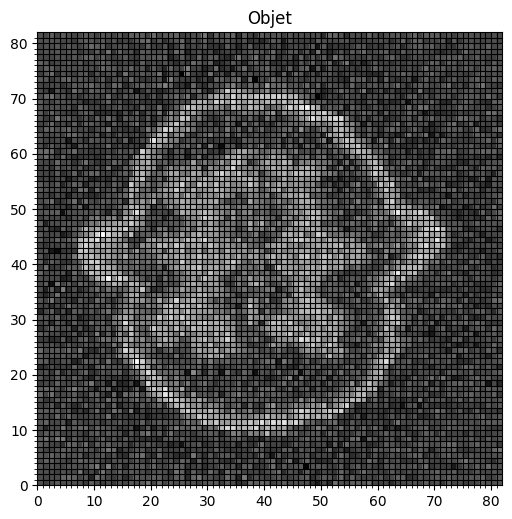

In [0]:
import pandas as pd
dataproj5 = pd.read_fwf('/content/dataproj5.txt', header = None)
dataproj5 = dataproj5.to_numpy()
print(dataproj5.shape)
print(dataproj5.flatten().shape)

epsilon = 10**-0.5
nEps = 12
m = math.floor(math.sqrt(nEps))
n = math.ceil(nEps/m)


bMesure = dataproj5.T.flatten()
N=82
theta=np.arange(0,179,4.5)
p=82
A ,_ ,p = paralleltomo(N,theta,p)
print(A.shape)

b_ = np.concatenate( (bMesure, np.zeros(N**2) ) ,axis=0)
A_ = np.concatenate( (A, epsilon*np.eye(N**2) ),axis = 0)
fReconst = np.linalg.lstsq(A_,b_) 
fReconst = np.array(fReconst[0])

fig = plt.figure(figsize=(6, 6),dpi=100 )
ax = fig.gca()
ax.set_title('Objet')

ax.set_xticks(range(N), minor=True)
ax.set_yticks(range(N), minor=True)
ax.pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
ax.grid(True, which = 'both', color = 'k')


(82, 40)
(3280,)
(3280, 6724)
0
240.45612788200378
1
240.93340969085693
2
242.40213990211487
3
240.506365776062


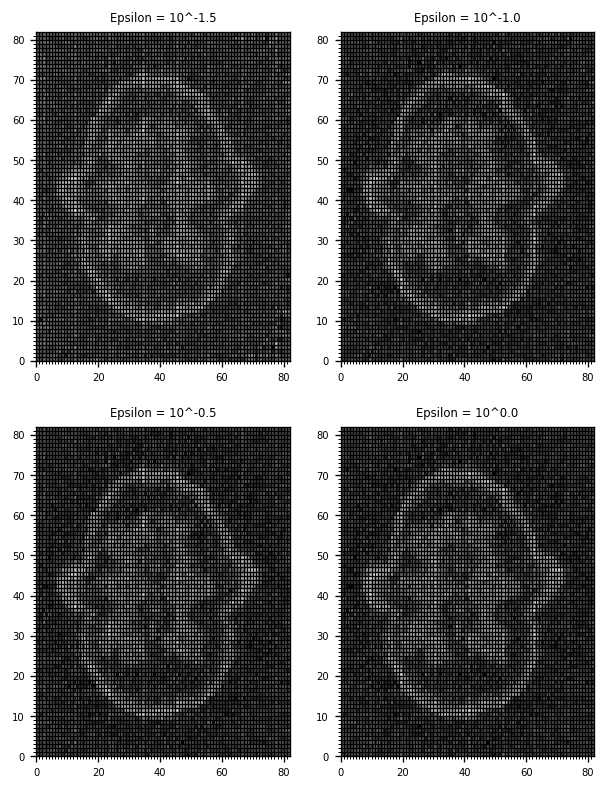

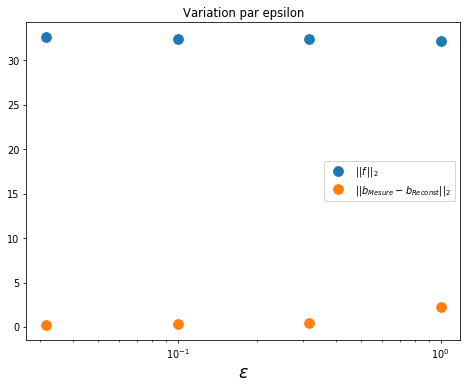

In [0]:
import pandas as pd
import time

dataproj5 = pd.read_fwf('/content/dataproj5.txt', header = None)
dataproj5 = dataproj5.to_numpy()
print(dataproj5.shape)
print(dataproj5.flatten().shape)

epsilon = 10**-1.5
nEps = 4
m = math.floor(math.sqrt(nEps))
n = math.ceil(nEps/m)
bMesure = dataproj5.T.flatten()

N=82
theta=np.arange(0,179,4.5)
p=82
A ,_ ,p = paralleltomo(N,theta,p)
print(A.shape)
b_ = np.concatenate( (bMesure, np.zeros(N**2) ) ,axis=0)

vecEps = np.zeros(nEps)
modf = np.zeros(nEps)
errB = np.zeros(nEps)


fig, ax = plt.subplots(m,n, figsize= (6,8), dpi = 120 )
ax = ax.flatten()

for i in range(nEps):

    A_ = np.concatenate( (A, epsilon*np.eye(N**2) ),axis = 0)
    #b_ = np.concatenate( (bMesure, epsilon*sigma*np.random.randn(N**2)) ,axis=0)
    start = time.time()
    print(i)
    Solver = np.linalg.lstsq(A_,b_, rcond = -1) 
    fReconst = np.array(Solver[0])
    end = time.time()
    print(end - start)
    bReconst = np.matmul(A,fReconst)
    
    vecEps[i] = epsilon
    modf[i] = np.linalg.norm(fReconst)
    errB[i] = np.linalg.norm(bReconst-bMesure)
    
    ax[i].set_xticks(range(N), minor=True)
    ax[i].set_yticks(range(N), minor=True)
    ax[i].pcolor(np.reshape(fReconst,(N,N)).T, cmap = 'gray')
    ax[i].set_title("Epsilon = 10^" + str(round(math.log10(epsilon),3)), fontsize = 7)
    ax[i].tick_params(axis='both', which='both', labelsize=6)
    ax[i].grid(True, which = 'both', color = 'k')
    epsilon = epsilon*math.sqrt(10);


fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Variation par epsilon')
ax.set_xlabel('$\epsilon$', fontsize= 18)
ax.semilogx(vecEps,modf,'.',vecEps,errB,'.', MarkerSize = 20)
ax.legend(['$||f\,||_2$','$||b_{Mesure} - b_{Reconst}||_2$'])

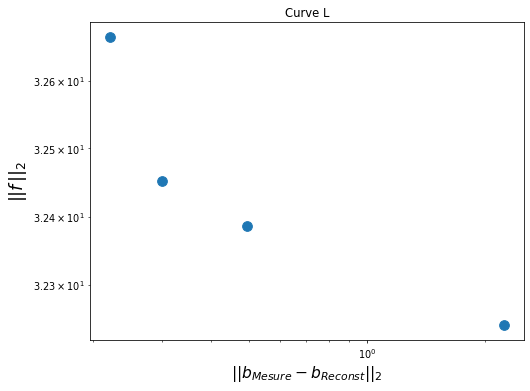

In [0]:
fig = plt.figure(figsize=(8, 6), dpi=70 )
ax = fig.gca()
ax.set_title('Curve L')
ax.set_xlabel('$||b_{Mesure} - b_{Reconst}||_2$', fontsize= 16)
ax.set_ylabel('$||f\,||_2$', fontsize= 18)
ax.loglog(errB,modf,'.', MarkerSize = 20)



<blockquote>

&nbsp;&nbsp;&nbsp;&nbsp; Pour le dernier ensemble de code ci-dessus, on va essayer de retrouver la forme d'un objet complètement inconnu, en faisant l'inversion des données avec la méthode de régularisation de Tikhonov.

&nbsp;&nbsp;&nbsp;&nbsp; Sur la première figure ci-dessus, on montre l'inversion des données avec differentes valeurs de $\epsilon$. Ensuite, sur la deuxième figure on montre la diminution de la norme de la différence entre $b_{Mesure}$ et  $b_{Reconst}$ en fonction de la variation de $\epsilon$. 

&nbsp;&nbsp;&nbsp;&nbsp; Une fois de plus, nous constatons que pour les valeurs trop petites de $\epsilon$, la forme retrouvée est de très basse qualité (elle s'approche de la solution donnée pour la méthode de moindres carrés). Par contre, pour les <b>valeurs intermédiaires</b> de $\epsilon$, les resultats sont assez bons, et lorsque que $\epsilon$ augmente beaucoup, on perdre la qualité. Plus specifiquement, nous constatons qu'une fois de plus la valuer $\epsilon = 10^{-0.5}$ peut être choisie comme optimale.